In [89]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('model_matchups_round2_classic_historical.csv')
print(df.shape)
df.head()

(240, 80)


,game_id,id,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,high_bracket_score,...,d_b,d_c,d_d,d_f,f_s,f_a,f_b,f_c,f_d,f_f
0,20082109,2109,2008,East,Second Round,1,2008 North Carolina,9,2008 Arkansas,108,...,0,0,0,0,0,0,0,0,0,0
1,20082110,2110,2008,East,Second Round,5,2008 Notre Dame,4,2008 Washington St.,41,...,0,0,0,0,0,0,0,0,0,0
2,20082111,2111,2008,East,Second Round,6,2008 Oklahoma,3,2008 Louisville,48,...,0,0,0,0,0,0,0,0,0,0
3,20082112,2112,2008,East,Second Round,7,2008 Butler,2,2008 Tennessee,71,...,0,0,0,0,0,0,0,0,0,0
4,20082209,2209,2008,Midwest,Second Round,1,2008 Kansas,8,2008 UNLV,75,...,0,0,0,0,0,0,0,0,0,0


In [90]:
df.columns.to_list()

['game_id',
 'id',
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'high_bracket_score',
 'low_bracket_score',
 'point_diff',
 'point_total',
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f',
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f',
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f',
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f',
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']

In [91]:
df['win'].value_counts()

0    123
1    117
Name: win, dtype: int64

# I. Check Tiers

In [92]:
s_tiers = df[[
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f']]
print(s_tiers.value_counts())
a_tiers = df[[
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f']]
print(a_tiers.value_counts())
b_tiers = df[[
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f']]
print(b_tiers.value_counts())
c_tiers = df[[
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f']]
print(c_tiers.value_counts())
d_tiers = df[[
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f']]
print(d_tiers.value_counts())
f_tiers = df[[
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']]
print(f_tiers.value_counts())

s_s  s_a  s_b  s_c  s_d  s_f
0    0    0    0    0    0      186
               1    0    0       50
          1    0    0    0        3
     1    0    0    0    0        1
dtype: int64
a_s  a_a  a_b  a_c  a_d  a_f
0    0    0    0    0    0      232
               1    0    0        3
          1    0    0    0        3
          0    0    1    0        1
1    0    0    0    0    0        1
dtype: int64
b_s  b_a  b_b  b_c  b_d  b_f
0    0    0    0    0    0      212
1    0    0    0    0    0        9
0    0    0    1    0    0        7
     1    0    0    0    0        6
     0    0    0    0    1        2
                    1    0        2
          1    0    0    0        2
dtype: int64
c_s  c_a  c_b  c_c  c_d  c_f
0    0    0    0    0    0      105
     1    0    0    0    0       36
1    0    0    0    0    0       32
0    0    1    0    0    0       27
          0    1    0    0       21
               0    0    1       10
                    1    0        9
dtype: int64
d_s 

In [93]:
# Remove all tier matchups that happened three or less times and view win percentage of the the remaining tiers
all_tiers = df[[
 'win',
 's_c',
 'b_s',
 'b_c',
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f',
 'd_b']]

In [94]:
all_tiers.groupby(by=['win', 's_c']).size()

win  s_c
0    0      116
     1        7
1    0       74
     1       43
dtype: int64

In [95]:
all_tiers.groupby(by=['win', 'b_s']).size()

win  b_s
0    0      117
     1        6
1    0      114
     1        3
dtype: int64

In [96]:
all_tiers.groupby(by=['win', 'c_s']).size()

win  c_s
0    0      100
     1       23
1    0      108
     1        9
dtype: int64

In [97]:
all_tiers.groupby(by=['win', 'c_a']).size()

win  c_a
0    0       95
     1       28
1    0      109
     1        8
dtype: int64

In [98]:
all_tiers.groupby(by=['win', 'c_b']).size()

win  c_b
0    0      106
     1       17
1    0      107
     1       10
dtype: int64

In [99]:
all_tiers.groupby(by=['win', 'c_c']).size()

win  c_c
0    0      111
     1       12
1    0      108
     1        9
dtype: int64

In [100]:
all_tiers.groupby(by=['win', 'c_d']).size()

win  c_d
0    0      121
     1        2
1    0      110
     1        7
dtype: int64

In [101]:
all_tiers.groupby(by=['win', 'c_f']).size()

win  c_f
0    0      121
     1        2
1    0      109
     1        8
dtype: int64

In [102]:
# Remove any tier with win percentages under 60% and greater than 40% and keep only columns that can be included in a model
eda_df = df[[
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_c',
 'b_s',
 'c_s',
 'c_a',
 'c_b',
 'c_d',
 'c_f']]
eda_df.shape

(240, 38)

In [103]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape

((192, 37), (48, 37))

In [104]:
y_train.shape, y_test.shape

((192,), (48,))

In [105]:
X_train.head()

,ovr_rating_bpi,ovr_rating_kenpom,ovr_rating_torvik,wab,off_rating_bpi,off_rating_kenpom,off_rating_torvik,def_rating_bpi,def_rating_kenpom,def_rating_torvik,...,size,bench,adj_tempo,s_c,b_s,c_s,c_a,c_b,c_d,c_f
110,7.6000,14.2775,0.2288,3.0526,2.9000,16.4810,17.1098,4.8000,-1.7611,-1.5658,...,0.6600,-11.0700,-3.1000,0,0,0,0,0,0,1
239,-7.4000,-12.8002,-0.1015,-6.7992,-7.0000,-6.1123,-7.7896,-0.4000,-8.1271,-4.1522,...,0.7100,-1.5200,-1.9000,0,0,1,0,0,0,0
63,-9.1000,-5.7826,-0.0665,-3.9260,-3.2000,2.3315,0.6923,-5.9000,-7.9667,-6.1245,...,0.6600,-0.4800,3.0000,0,0,0,1,0,0,0
153,-1.4000,-1.1106,-0.0130,0.9209,2.4000,11.6532,9.4814,-3.8000,-13.2080,-11.1129,...,-0.1900,-0.0600,0.5000,0,0,0,0,0,0,0
233,-0.8000,-2.4438,-0.0213,0.2334,4.2000,15.4497,12.9391,-5.0000,-17.8634,-13.8847,...,-1.7800,-4.9200,0.5000,0,0,0,0,0,0,0


In [106]:
X_train.columns.to_list()

['ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_c',
 'b_s',
 'c_s',
 'c_a',
 'c_b',
 'c_d',
 'c_f']

# II. Box Plots

<Axes: xlabel='win', ylabel='ovr_rating_bpi'>

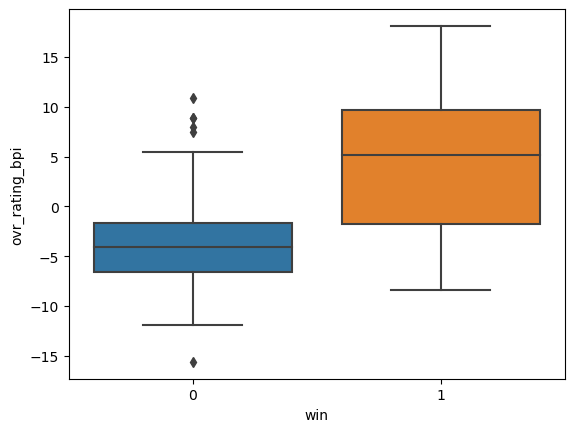

In [107]:
sns.boxplot(data=df, x='win', y='ovr_rating_bpi')

<Axes: xlabel='win', ylabel='ovr_rating_kenpom'>

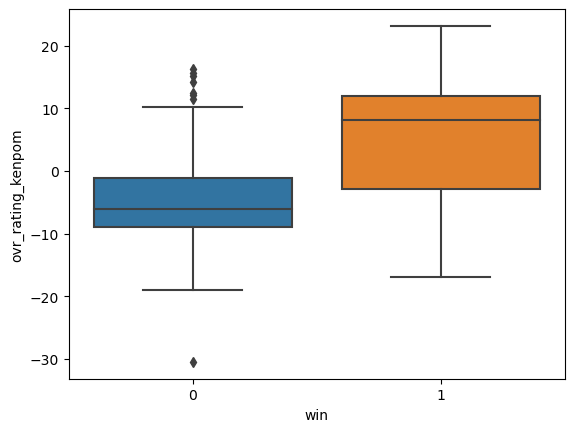

In [108]:
sns.boxplot(data=df, x='win', y='ovr_rating_kenpom')

<Axes: xlabel='win', ylabel='ovr_rating_torvik'>

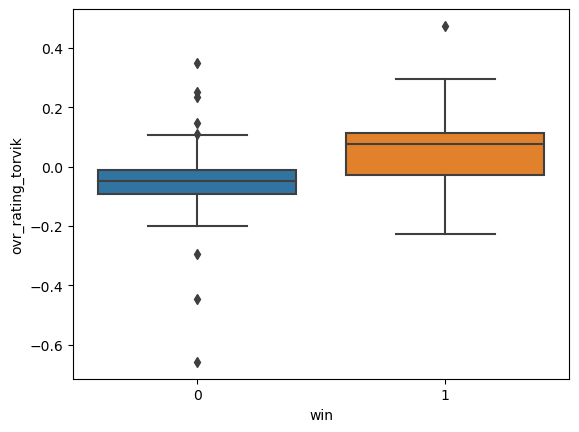

In [109]:
sns.boxplot(data=df, x='win', y='ovr_rating_torvik')

<Axes: xlabel='win', ylabel='wab'>

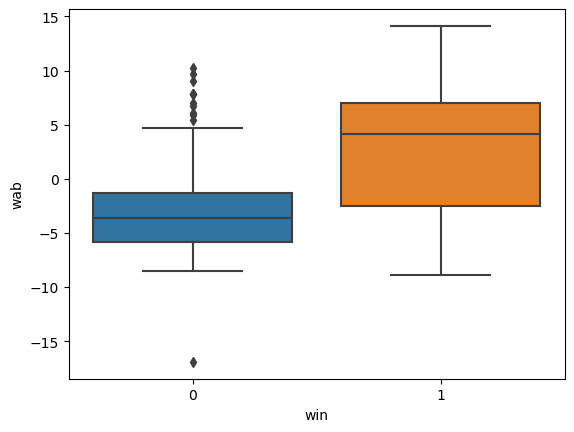

In [110]:
sns.boxplot(data=df, x='win', y='wab')

<Axes: xlabel='win', ylabel='off_rating_bpi'>

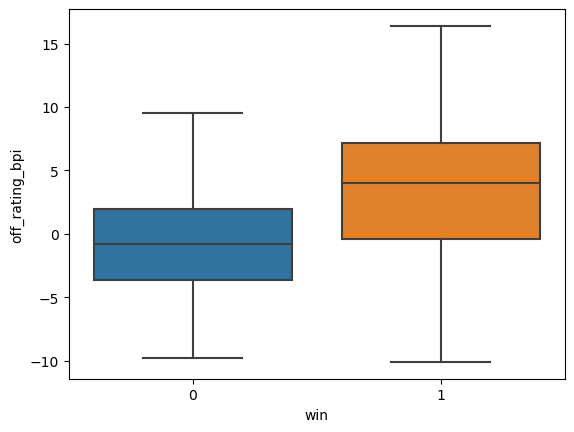

In [111]:
sns.boxplot(data=df, x='win', y='off_rating_bpi')

<Axes: xlabel='win', ylabel='off_rating_kenpom'>

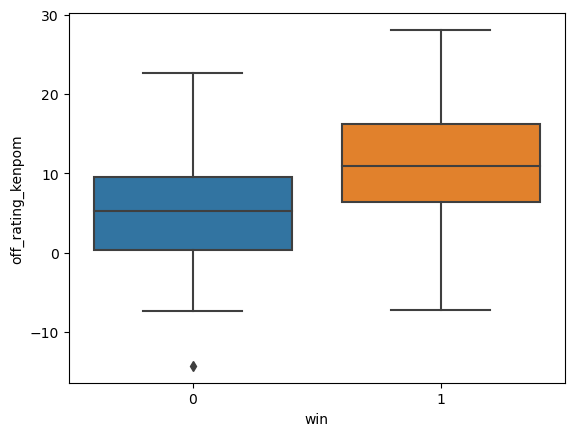

In [112]:
sns.boxplot(data=df, x='win', y='off_rating_kenpom')

<Axes: xlabel='win', ylabel='off_rating_torvik'>

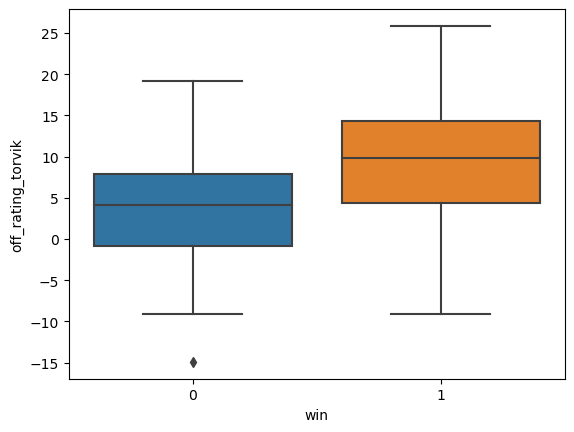

In [113]:
sns.boxplot(data=df, x='win', y='off_rating_torvik')

<Axes: xlabel='win', ylabel='def_rating_torvik'>

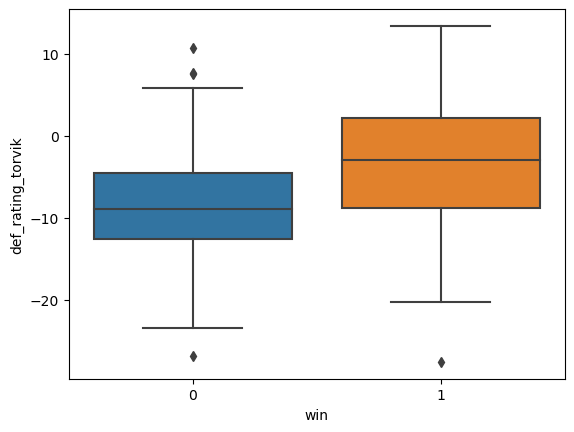

In [114]:
sns.boxplot(data=df, x='win', y='def_rating_torvik')

<Axes: xlabel='win', ylabel='efg%_off'>

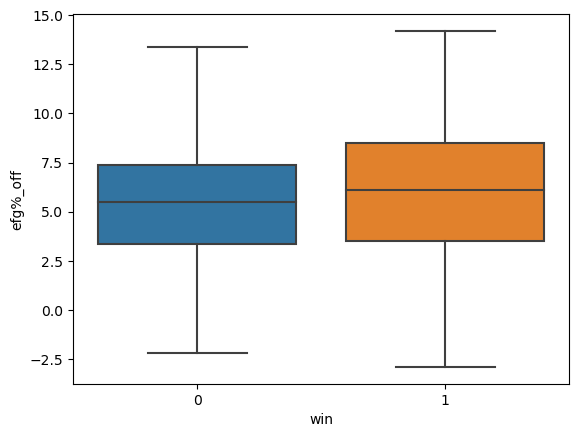

In [115]:
sns.boxplot(data=df, x='win', y='efg%_off')

<Axes: xlabel='win', ylabel='ftr_off'>

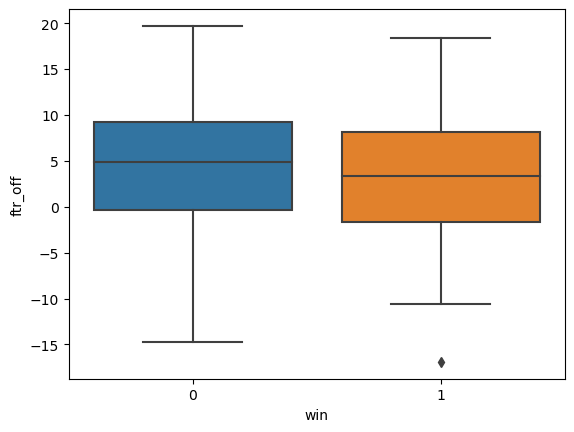

In [116]:
sns.boxplot(data=df, x='win', y='ftr_off')

<Axes: xlabel='win', ylabel='reb%_off'>

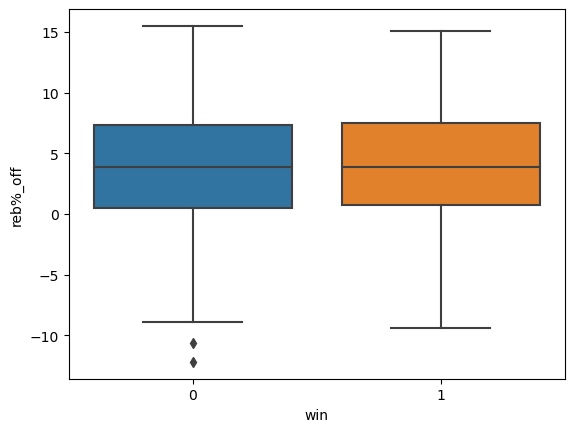

In [117]:
sns.boxplot(data=df, x='win', y='reb%_off')

<Axes: xlabel='win', ylabel='to%_off'>

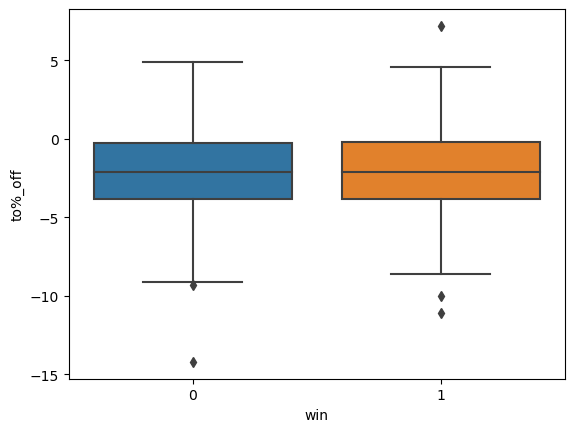

In [118]:
sns.boxplot(data=df, x='win', y='to%_off')

<Axes: xlabel='win', ylabel='efg%_def'>

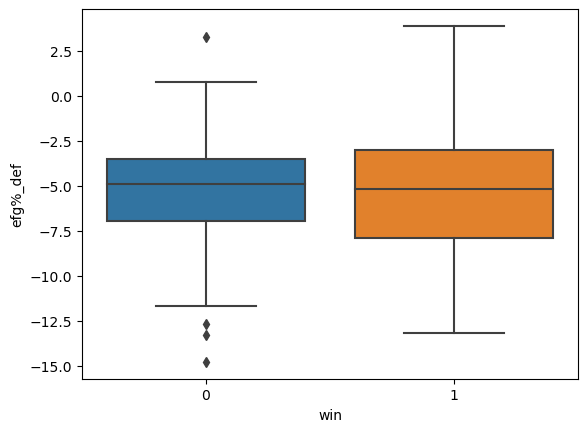

In [119]:
sns.boxplot(data=df, x='win', y='efg%_def')

<Axes: xlabel='win', ylabel='ftr_def'>

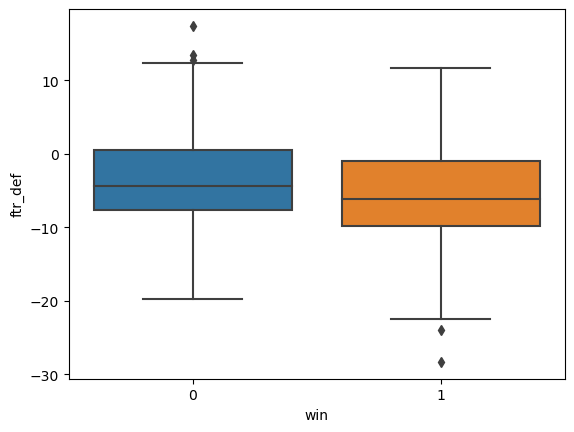

In [120]:
sns.boxplot(data=df, x='win', y='ftr_def')

<Axes: xlabel='win', ylabel='reb%_def'>

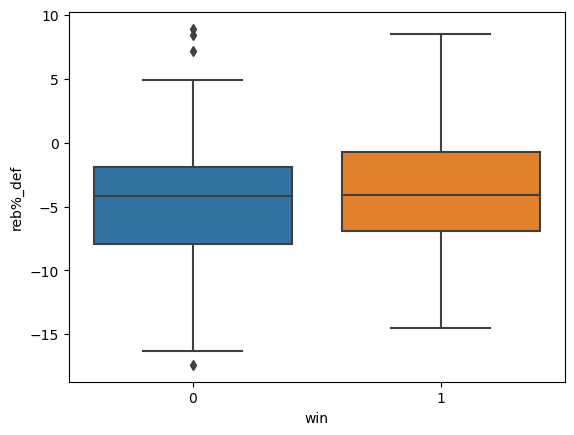

In [121]:
sns.boxplot(data=df, x='win', y='reb%_def')

<Axes: xlabel='win', ylabel='to%_def'>

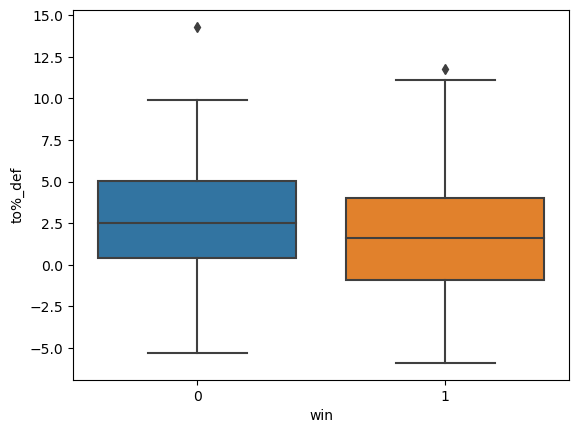

In [122]:
sns.boxplot(data=df, x='win', y='to%_def')

<Axes: xlabel='win', ylabel='2p%_off'>

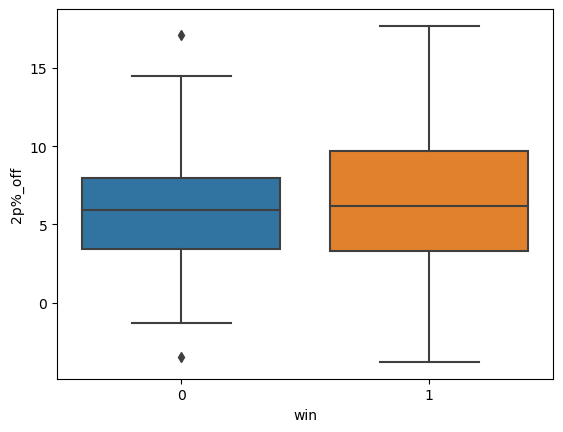

In [123]:
sns.boxplot(data=df, x='win', y='2p%_off')

<Axes: xlabel='win', ylabel='3p%_off'>

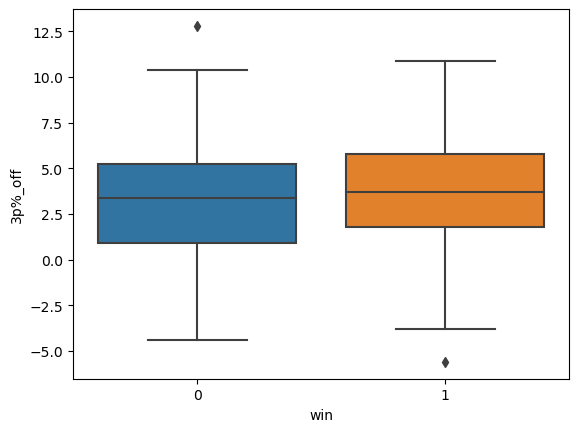

In [124]:
sns.boxplot(data=df, x='win', y='3p%_off')

<Axes: xlabel='win', ylabel='eff_off'>

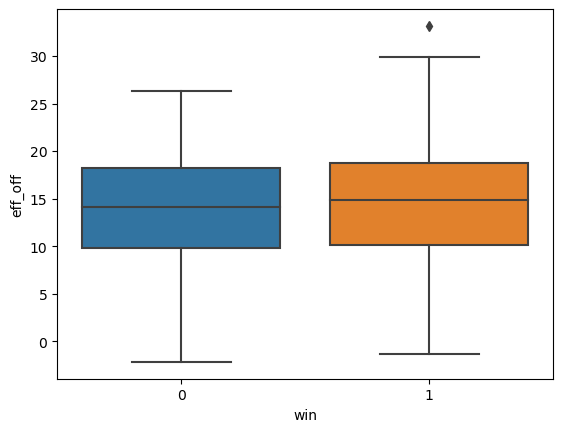

In [125]:
sns.boxplot(data=df, x='win', y='eff_off')

<Axes: xlabel='win', ylabel='ft%_off'>

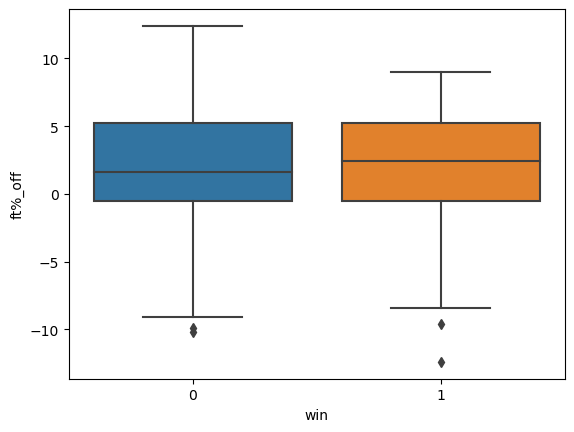

In [126]:
sns.boxplot(data=df, x='win', y='ft%_off')

<Axes: xlabel='win', ylabel='2p%_def'>

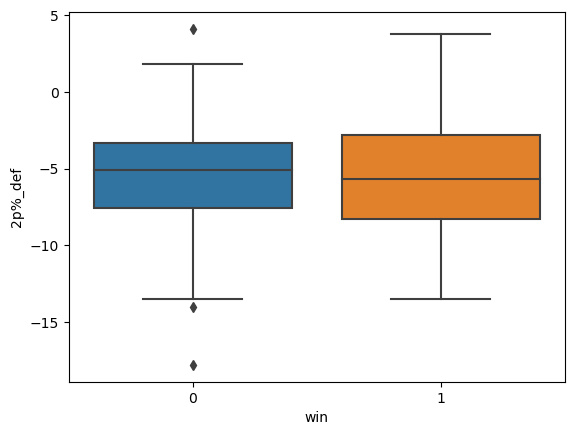

In [127]:
sns.boxplot(data=df, x='win', y='2p%_def')

<Axes: xlabel='win', ylabel='3p%_def'>

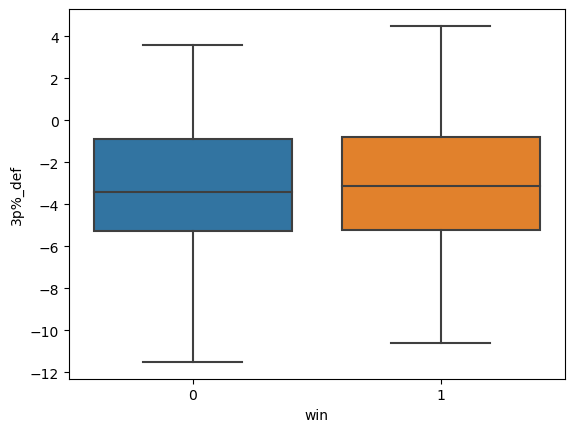

In [128]:
sns.boxplot(data=df, x='win', y='3p%_def')

<Axes: xlabel='win', ylabel='eff_def'>

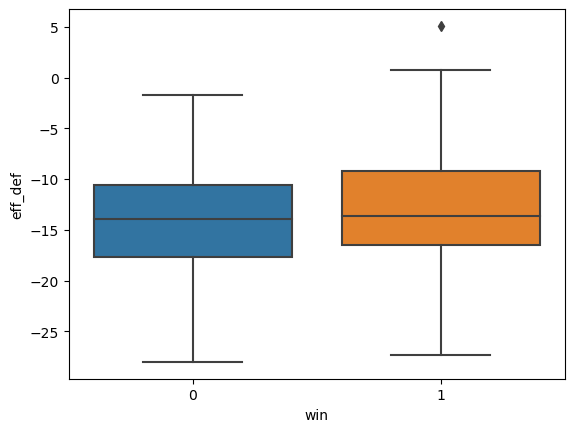

In [129]:
sns.boxplot(data=df, x='win', y='eff_def')

<Axes: xlabel='win', ylabel='ft%_def'>

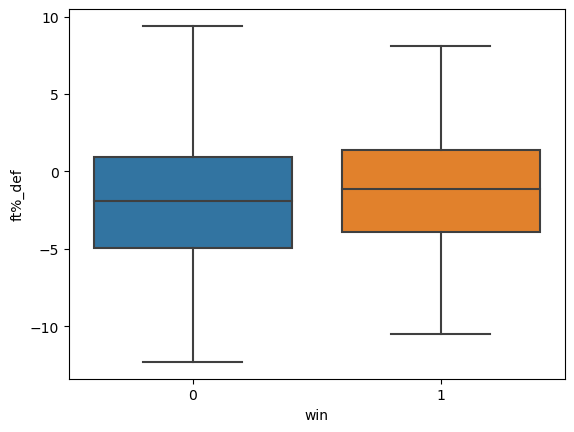

In [130]:
sns.boxplot(data=df, x='win', y='ft%_def')

<Axes: xlabel='win', ylabel='height_eff'>

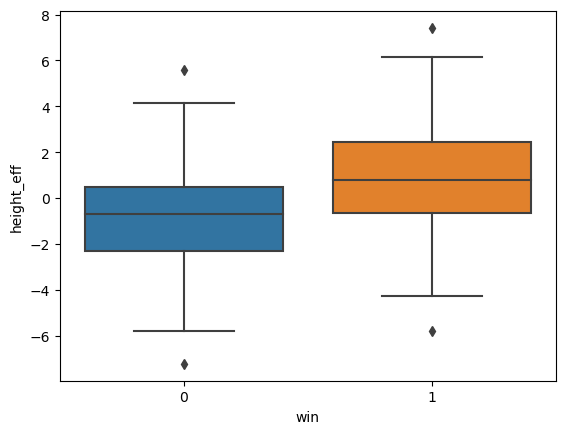

In [131]:
sns.boxplot(data=df, x='win', y='height_eff')

<Axes: xlabel='win', ylabel='size'>

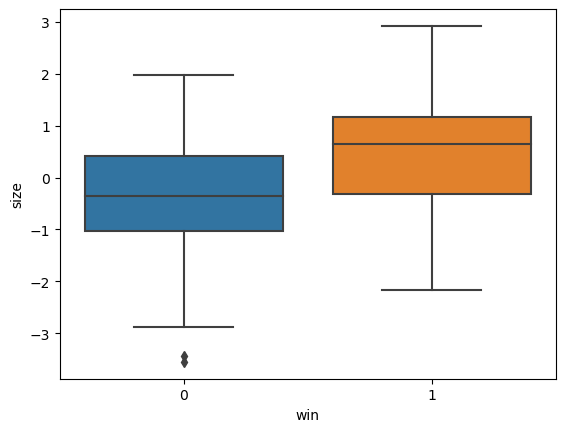

In [132]:
sns.boxplot(data=df, x='win', y='size')

<Axes: xlabel='win', ylabel='bench'>

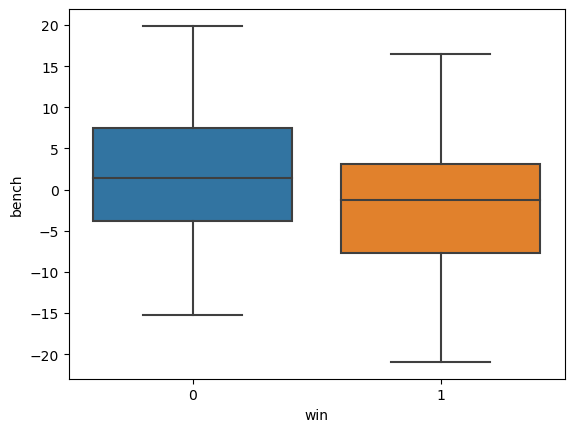

In [133]:
sns.boxplot(data=df, x='win', y='bench')

<Axes: xlabel='win', ylabel='adj_tempo'>

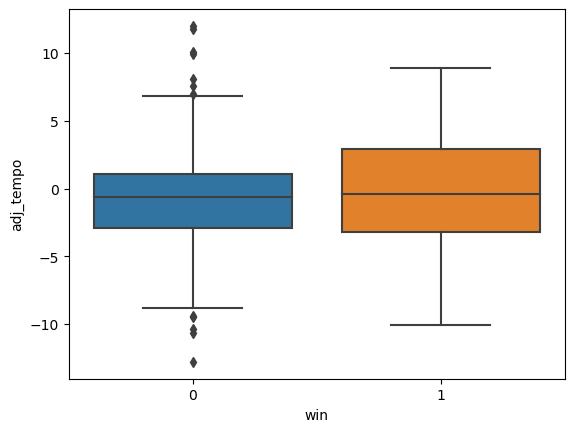

In [134]:
sns.boxplot(data=df, x='win', y='adj_tempo')

# III. Mutual Information

Text(0, 0.5, 'Mutual Information')

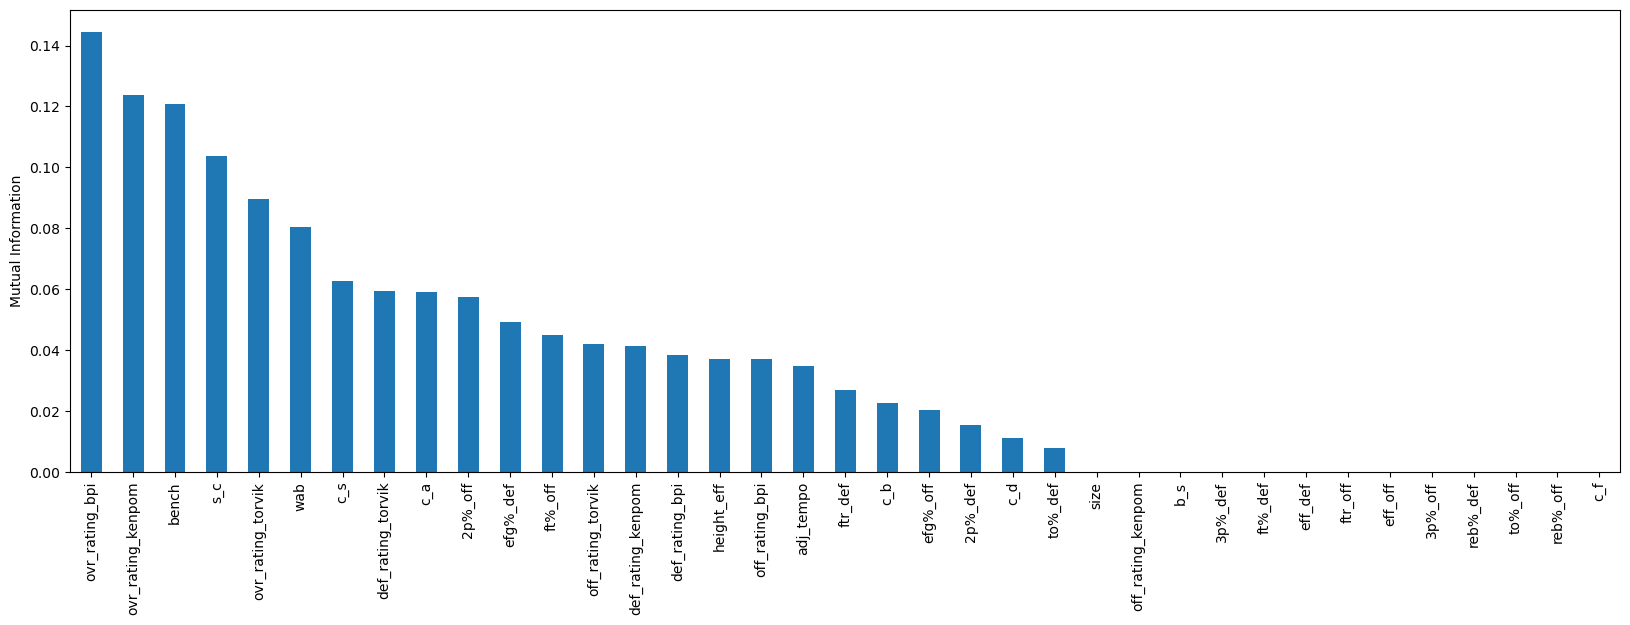

In [135]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [136]:
mi

ovr_rating_bpi      0.1446
ovr_rating_kenpom   0.1238
ovr_rating_torvik   0.0897
wab                 0.0804
off_rating_bpi      0.0372
off_rating_kenpom   0.0000
off_rating_torvik   0.0421
def_rating_bpi      0.0382
def_rating_kenpom   0.0414
def_rating_torvik   0.0592
efg%_off            0.0203
ftr_off             0.0000
reb%_off            0.0000
to%_off             0.0000
efg%_def            0.0493
ftr_def             0.0269
reb%_def            0.0000
to%_def             0.0078
2p%_off             0.0574
3p%_off             0.0000
eff_off             0.0000
ft%_off             0.0449
2p%_def             0.0154
3p%_def             0.0000
eff_def             0.0000
ft%_def             0.0000
height_eff          0.0372
size                0.0000
bench               0.1209
adj_tempo           0.0348
s_c                 0.1037
b_s                 0.0000
c_s                 0.0628
c_a                 0.0589
c_b                 0.0225
c_d                 0.0111
c_f                 0.0000
d

In [137]:
sel_ = SelectKBest(f_classif, k=10).fit(X_train, y_train)
X_train.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'off_rating_bpi', 'off_rating_kenpom', 'off_rating_torvik',
       'def_rating_bpi', 'size', 's_c'],
      dtype='object')

# IV. ANOVA

In [138]:
X_num = X_train[[
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo']]

X_cat = X_train[[
    's_c',
    'b_s',
    'c_s',
    'c_a',
    'c_b',
    'c_d',
    'c_f']]

<Axes: >

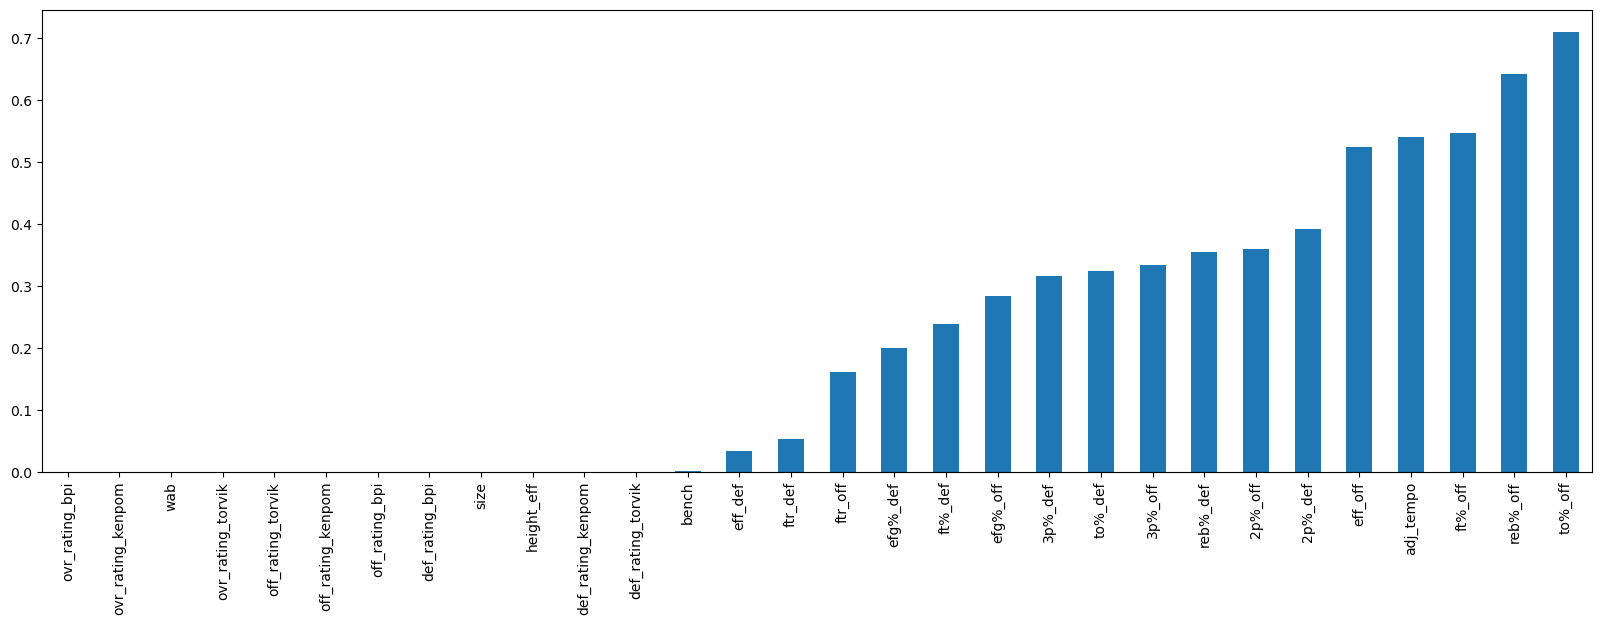

In [139]:
univariate = f_classif(X_num, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_num.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6))

In [140]:
univariate

ovr_rating_bpi      0.0000
ovr_rating_kenpom   0.0000
ovr_rating_torvik   0.0000
wab                 0.0000
off_rating_bpi      0.0000
off_rating_kenpom   0.0000
off_rating_torvik   0.0000
def_rating_bpi      0.0000
def_rating_kenpom   0.0000
def_rating_torvik   0.0001
efg%_off            0.2837
ftr_off             0.1614
reb%_off            0.6420
to%_off             0.7106
efg%_def            0.1996
ftr_def             0.0529
reb%_def            0.3554
to%_def             0.3234
2p%_off             0.3600
3p%_off             0.3331
eff_off             0.5240
ft%_off             0.5466
2p%_def             0.3918
3p%_def             0.3157
eff_def             0.0334
ft%_def             0.2389
height_eff          0.0000
size                0.0000
bench               0.0010
adj_tempo           0.5401
dtype: float64

In [141]:
sel_ = SelectKBest(f_classif, k=10).fit(X_num, y_train)
X_num.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'off_rating_bpi', 'off_rating_kenpom', 'off_rating_torvik',
       'def_rating_bpi', 'height_eff', 'size'],
      dtype='object')

# V. Chi Squared

In [142]:
chi_ls = []

for feature in X_cat.columns:
    c = pd.crosstab(y_train, X_cat[feature])
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

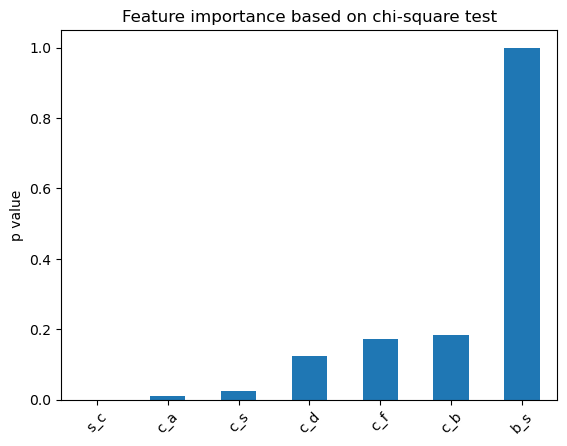

In [143]:
pd.Series(chi_ls, index=X_cat.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [144]:
chi_ls

[1.6023705504488798e-06,
 1.0,
 0.024495070038514238,
 0.009768989503858109,
 0.1823661901498455,
 0.12351281770642716,
 0.172024754622972]

# VI. Lasso Regression

In [145]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [146]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [147]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 37
selected features: 19
features with coefficients shrank to zero: 18


In [148]:
selected_feat

Index(['ovr_rating_bpi', 'wab', 'def_rating_kenpom', 'reb%_off', 'to%_off',
       'efg%_def', 'to%_def', 'eff_off', '2p%_def', 'ft%_def', 'height_eff',
       'size', 'bench', 'adj_tempo', 's_c', 'b_s', 'c_s', 'c_a', 'c_d'],
      dtype='object')

# VII. Backward Selection

In [149]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [150]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [151]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['ovr_rating_bpi', 'ovr_rating_torvik', 'off_rating_kenpom',
       'off_rating_torvik', 'efg%_def', 'eff_def', 'adj_tempo', 'c_s',
       'c_a', 'c_f'], dtype=object)

In [152]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9125434027777778
Test set
Random Forests roc-auc: 0.8412698412698413


In [153]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9430338541666667
Test set
Random Forests roc-auc: 0.925925925925926


In [154]:
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
rf.fit(X_train, y_train)

print('Train set')
pred = rf.predict_proba(X_train)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
print('Test set')
pred = rf.predict_proba(X_test)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set
Random Forests roc-auc: 0.9430338541666667
Test set
Random Forests roc-auc: 0.925925925925926


In [155]:
rf.feature_importances_

array([0.1311, 0.0688, 0.1082, 0.0705, 0.0389, 0.0424, 0.0737, 0.0268,
       0.0386, 0.0340, 0.0202, 0.0141, 0.0209, 0.0144, 0.0275, 0.0091,
       0.0114, 0.0053, 0.0146, 0.0094, 0.0127, 0.0088, 0.0343, 0.0093,
       0.0099, 0.0124, 0.0334, 0.0371, 0.0338, 0.0096, 0.0161, 0.0000,
       0.0000, 0.0017, 0.0001, 0.0000, 0.0013])

### This averages 14.88 out of 16 correct games per season. Can you even get higher without overfitting? 

# IX. ROC-AUC

In [156]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.8227513227513228,
 0.6604938271604939,
 0.6587301587301587,
 0.6798941798941799,
 0.5961199294532628,
 0.5687830687830688,
 0.5793650793650794,
 0.7610229276895943,
 0.6772486772486772,
 0.7698412698412699,
 0.3765432098765432,
 0.4559082892416225,
 0.4576719576719577,
 0.4964726631393298,
 0.47619047619047616,
 0.5405643738977073,
 0.5035273368606701,
 0.5714285714285714,
 0.48412698412698413,
 0.4929453262786596,
 0.544973544973545,
 0.5502645502645502,
 0.5141093474426808,
 0.5537918871252205,
 0.44179894179894186,
 0.525573192239859,
 0.5855379188712523,
 0.5634920634920636,
 0.4708994708994709,
 0.43033509700176364,
 0.6957671957671958,
 0.5,
 0.5317460317460317,
 0.6111111111111112,
 0.4894179894179894,
 0.5052910052910053,
 0.5238095238095238]

Text(0, 0.5, 'roc-auc')

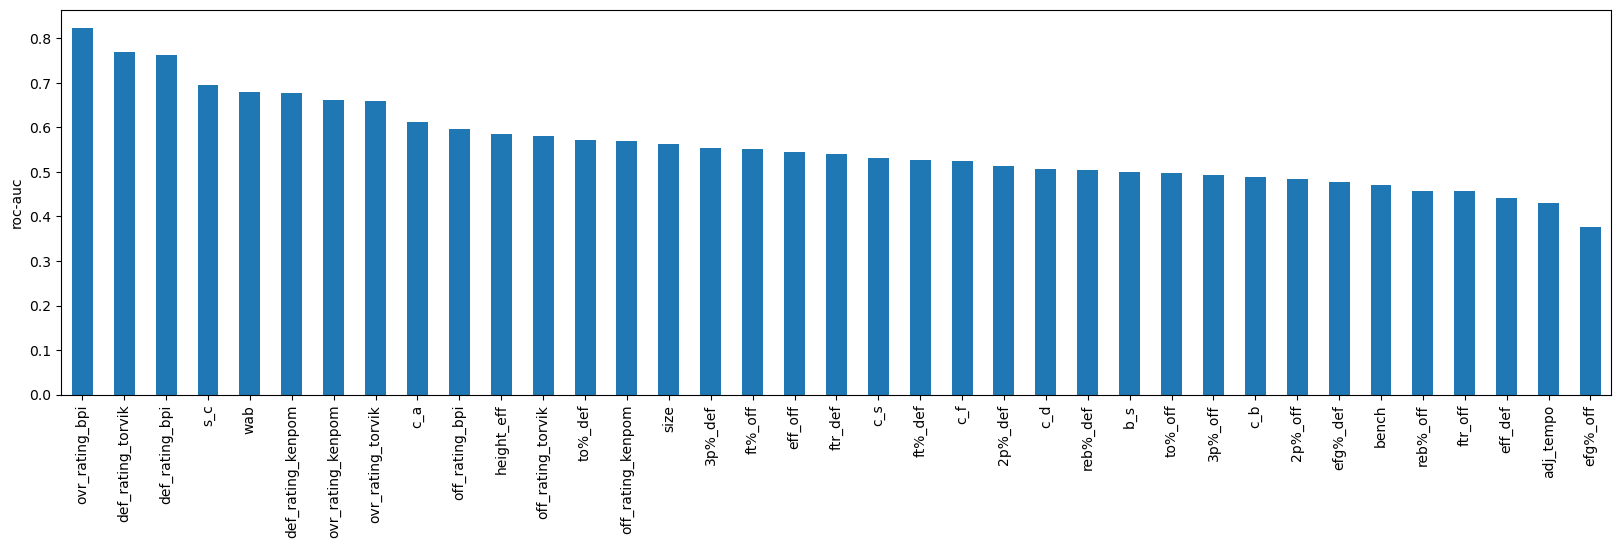

In [157]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [158]:
len(roc_values[roc_values > 0.5])

25

In [159]:
len(roc_values[roc_values > 0.6])

9

# X. Feature Selection

In [160]:
# Using all features with any importance from the full dataset random forest and will try different hyperparameters
model_df = df[[
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_c',
 'c_a',
 'c_b',
 'c_f']]
model_df.to_csv('model_features_round2_classic_historical.csv')